## Perturbation effect predictions with baseline linear model

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from linear_pretrained_model import *
# Add the parent directory to sys.path to import modules from there
sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

## Load and pseudobulk Replogle et al. 2022

This takes a bit of RAM

In [3]:
# adata_k562 = sc.read_h5ad('/mnt/oak/users/emma/data/wesvae-data/K562_gwps.h5ad')
# perturbation_col = 'gene'
# adata_bulk = sc.get.aggregate(adata_k562, by=perturbation_col, func=['mean'])
# adata_bulk.X = adata_bulk.layers['mean']
# adata_bulk.write_h5ad(f"/mnt/oak/users/emma/data/wesvae-data/K562_gwps.prediction_pseudobulk.h5ad")

In [3]:
adata_k562 = sc.read_h5ad(f"/mnt/oak/users/emma/data/wesvae-data/K562_gwps.prediction_pseudobulk.h5ad")

## Load pseudobulked T cell dataset

In [200]:
datadir = '/mnt/oak/users/emma/data/GWT/CRiCD4_Run1_Illumina/'
experiment_name = 'CRiCD4_Run1_Illumina'

adata_rest_d1 = sc.read_h5ad(datadir + 'perturbation_prediction/CRiCD4_Run1_Illumina.prediction_pseudobulk.CE0008162-Rest.h5ad')
adata_rest_d2 = sc.read_h5ad(datadir + 'perturbation_prediction/CRiCD4_Run1_Illumina.prediction_pseudobulk.CE0010866-Rest.h5ad')
adata_stim_d1 = sc.read_h5ad(datadir + 'perturbation_prediction/CRiCD4_Run1_Illumina.prediction_pseudobulk.CE0008162-Stim8hr.h5ad')
adata_stim_d2 = sc.read_h5ad(datadir + 'perturbation_prediction/CRiCD4_Run1_Illumina.prediction_pseudobulk.CE0010866-Stim8hr.h5ad')

In [201]:
# Keep common genes for prediction
common_genes = np.intersect1d(adata_k562.var_names, adata_stim_d1.var_names)

adata_k562 = adata_k562[:, common_genes].copy()
adata_rest_d1 = adata_rest_d1[:, common_genes].copy()
adata_rest_d2 = adata_rest_d2[:, common_genes].copy()
adata_stim_d1 = adata_stim_d1[:, common_genes].copy()
adata_stim_d2 = adata_stim_d2[:, common_genes].copy()

In [202]:
# Find intersection of obs_names for all loaded anndatas
common_obs_names = np.intersect1d(
    np.intersect1d(
        np.intersect1d(adata_k562.obs_names, adata_rest_d1.obs_names),
        np.intersect1d(adata_rest_d2.obs_names, adata_stim_d1.obs_names)
    ),
    adata_stim_d2.obs_names
)

# Find those that are measured
keep_perturbations = list(np.intersect1d(common_obs_names, adata_rest_d1.var['gene_name']))

adata_k562 = adata_k562[keep_perturbations + ['non-targeting']].copy()
adata_rest_d1 = adata_rest_d1[keep_perturbations + ['NTC']].copy()
adata_rest_d2 = adata_rest_d2[keep_perturbations + ['NTC']].copy()
adata_stim_d1 = adata_stim_d1[keep_perturbations + ['NTC']].copy()
adata_stim_d2 = adata_stim_d2[keep_perturbations + ['NTC']].copy()

In [205]:
len(keep_perturbations)

415

In [ ]:
datadir = '/mnt/oak/users/emma/data/GWT/CRiCD4_Run1_Illumina/'
experiment_name = 'CRiCD4_Run1_Illumina'
adata_de = sc.read_h5ad(datadir + f'/DE_results/{experiment_name}.merged_DE_results.h5ad')

In [204]:
n_cells_df = get_de_stats(adata_de).sort_values('n_cells_target')
keep_perturbations = n_cells_df.target_name[(n_cells_df.target_name.isin(keep_perturbations) & (n_cells_df['n_cells_target'] > 60) & (n_cells_df['condition'] == 'Stim8hr'))].unique().tolist()
adata_k562 = adata_k562[keep_perturbations + ['non-targeting']].copy()
adata_rest_d1 = adata_rest_d1[keep_perturbations + ['NTC']].copy()
adata_rest_d2 = adata_rest_d2[keep_perturbations + ['NTC']].copy()
adata_stim_d1 = adata_stim_d1[keep_perturbations + ['NTC']].copy()
adata_stim_d2 = adata_stim_d2[keep_perturbations + ['NTC']].copy()

## Predict unseen perturbs

In [206]:
def train_test_predict_model(adata, train_var_names_col='gene_name', control_level='NTC', train_size_fraction=0.8, seed=100):
    """
    Train a PerturbLinearEmbedding model on a subset of the data and evaluate predictions.
    
    Parameters:
    -----------
    adata : AnnData
        The annotated data matrix to use for training and testing.
    train_var_names_col : str, default='gene_name'
        Column in adata.var containing gene names.
    control_level : str, default='NTC'
        Identifier for control observations.
    train_size_fraction : float, default=0.8
        Fraction of observations to use for training.
    seed : int, default=100
        Random seed for reproducibility.
        
    Returns:
    --------
    pd.DataFrame
        Combined evaluation results for model and baseline predictions.
    """
    adata = adata.copy()
    
    # Split observations into train (80%) and test (20%) sets without replacement
    np.random.seed(seed)  # For reproducibility
    all_obs = [obs for obs in adata.obs_names.tolist() if obs != control_level]  # Exclude NTC from random split
    train_size = int(len(all_obs) * train_size_fraction)
    train_obs = np.random.choice(all_obs, size=train_size, replace=False).tolist()
    test_obs = [obs for obs in all_obs if obs not in train_obs]
    # Add NTC to both train and test sets
    train_obs = train_obs + [control_level]
    test_obs = test_obs
    # Create train and test AnnData objects
    adata_train = adata[train_obs].copy()
    adata_test = adata[test_obs].copy()

    # Move gene names to match perturbation ids
    adata_train.var_names = adata_train.var[train_var_names_col].values

    # Predict
    model = PerturbLinearEmbedding(pca_dim=20, ridge_lambda=0.1)
    model.fit(adata_train, use_layer='mean', control=control_level)
    predictions = model.predict(perturbations=adata_test.obs_names, add_baseline=True)

    ntc_expr = sc.get.var_df(adata, [control_level], layer='mean')
    ntc_expr.index = adata.var[train_var_names_col].values
    true_expr = sc.get.var_df(adata_test, predictions.columns.tolist(), layer='mean')
    true_expr.index = adata_test.var[train_var_names_col].values
    mean_baseline = pd.concat([pd.DataFrame(ntc_expr.mean(axis=1)) for _ in range(len(predictions.columns.tolist()))], axis=1)
    mean_baseline.columns = true_expr.columns

    results = eval_prediction(predictions, true_expr)
    results_baseline = eval_prediction(mean_baseline, true_expr)

    results['model'] = 'LM'
    results_baseline['model'] = 'mean baseline'

    all_results = pd.concat([results, results_baseline])
    return all_results

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['C1orf112', 'GCLC', 'NIPAL3', 'LAS1L', 'ANKIB1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


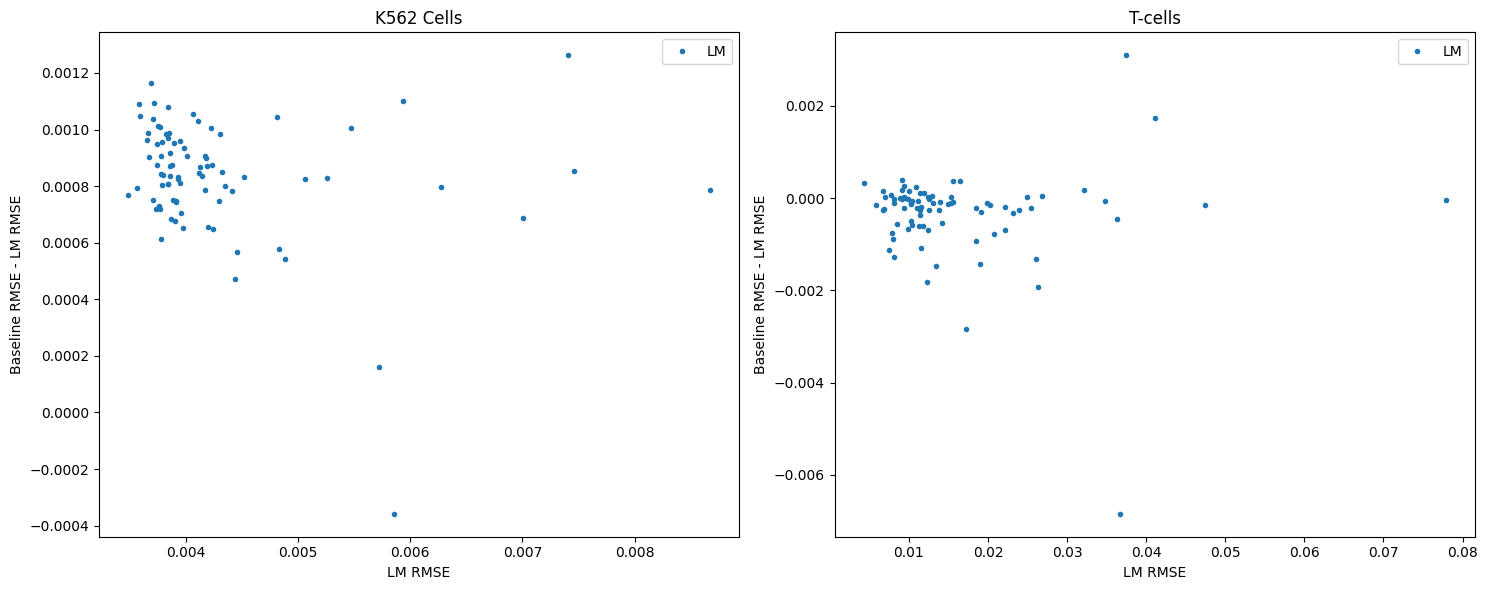

In [221]:
k562_pred = train_test_predict_model(adata_k562, control_level='non-targeting')
tcell_pred = train_test_predict_model(adata_stim_d1, control_level='NTC')

# Create scatter plots comparing LM vs baseline RMSE for both K562 and T-cells
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# K562 plot
k562_lm_rmse = k562_pred.pivot(columns='model', values='rmse')['LM']
k562_baseline_rmse = k562_pred.pivot(columns='model', values='rmse')['mean baseline']
k562_rmse_diff = k562_baseline_rmse - k562_lm_rmse
k562_sorted_indices = k562_rmse_diff.sort_values(ascending=False).index
k562_lm_rmse_sorted = k562_lm_rmse.loc[k562_sorted_indices]

n_ixs = min(10000, len(k562_lm_rmse_sorted))
ax1.plot(k562_lm_rmse_sorted.values[0:n_ixs], k562_rmse_diff.loc[k562_sorted_indices].values[0:n_ixs], '.', label='LM')
ax1.set_title('K562 Cells')
ax1.set_xlabel('LM RMSE')
ax1.set_ylabel('Baseline RMSE - LM RMSE')
ax1.legend()

# T-cells plot
tcell_lm_rmse = tcell_pred.pivot(columns='model', values='cosine_distance')['LM']
tcell_baseline_rmse = tcell_pred.pivot(columns='model', values='cosine_distance')['mean baseline']
tcell_rmse_diff = tcell_baseline_rmse - tcell_lm_rmse
tcell_sorted_indices = tcell_rmse_diff.sort_values(ascending=False).index
tcell_lm_rmse_sorted = tcell_lm_rmse.loc[tcell_sorted_indices]

n_ixs = min(10000, len(tcell_lm_rmse_sorted))
ax2.plot(tcell_lm_rmse_sorted.values[0:n_ixs], tcell_rmse_diff.loc[tcell_sorted_indices].values[0:n_ixs], '.', label='LM')
ax2.set_title('T-cells')
ax2.set_xlabel('LM RMSE')
ax2.set_ylabel('Baseline RMSE - LM RMSE')
ax2.legend()

plt.tight_layout()

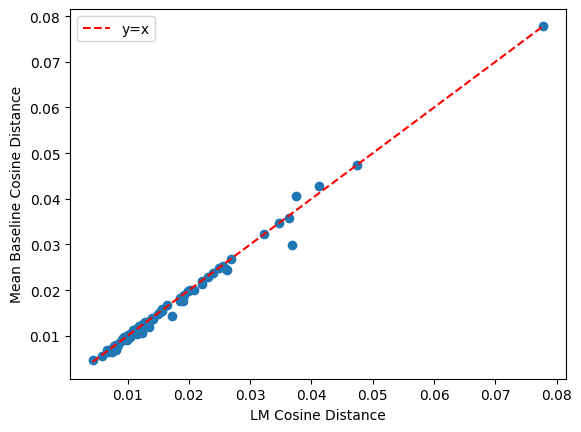

In [224]:
plt.scatter(tcell_lm_rmse, tcell_baseline_rmse)
# Add diagonal line for reference
min_val = min(tcell_lm_rmse.min(), tcell_baseline_rmse.min())
max_val = max(tcell_lm_rmse.max(), tcell_baseline_rmse.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x')
plt.xlabel('LM Cosine Distance')
plt.ylabel('Mean Baseline Cosine Distance')
plt.legend()

In [169]:
k562_pred

,perturbation,l2_distance,rmse,cosine_distance,pearson_r,pearson_pval,model
AAK1,AAK1,4.539658,0.004195,0.005716,0.989323,0.0,LM
AASDHPPT,AASDHPPT,4.371988,0.003891,0.005581,0.989643,0.0,LM
ABCA7,ABCA7,4.359349,0.003868,0.005343,0.990313,0.0,LM
ABCC5,ABCC5,4.293491,0.003752,0.005254,0.990460,0.0,LM
ABCE1,ABCE1,5.573008,0.006322,0.008903,0.983297,0.0,LM
...,...,...,...,...,...,...,...
ZNF684,ZNF684,4.995710,0.005080,0.006558,0.987792,0.0,mean baseline
ZNF76,ZNF76,4.806753,0.004703,0.006609,0.987773,0.0,mean baseline
ZNF8,ZNF8,5.009270,0.005107,0.007353,0.986368,0.0,mean baseline
ZNF92,ZNF92,4.767414,0.004626,0.006569,0.987769,0.0,mean baseline


0.12362475426129563


Text(0.5, 1.0, '2D Histogram for NET1: Ground Truth vs Mean Baseline')

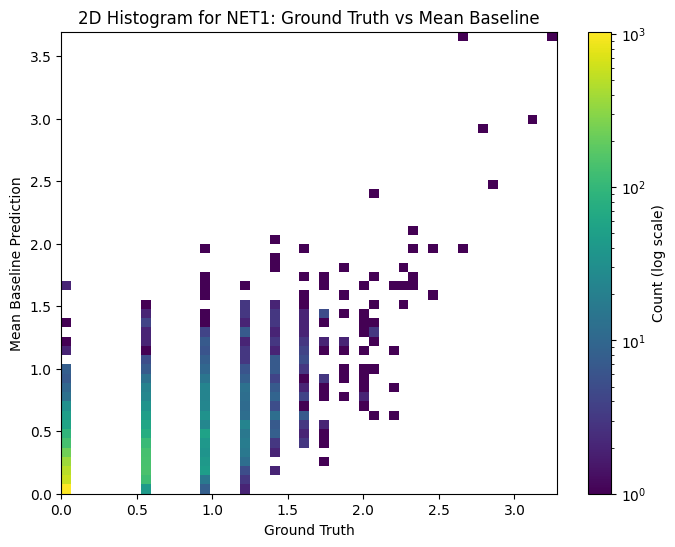

In [131]:
p = 'NET1'
groundtruth = true_expr[p]
pred = mean_baseline[p]
rmse_values = np.mean((groundtruth - pred) ** 2, axis=0)
print(rmse_values)

# Create 2D histogram instead of scatter plot
plt.figure(figsize=(8, 6))
h = plt.hist2d(groundtruth, pred, bins=50, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar(h[3], label='Count (log scale)')
plt.xlabel('Ground Truth')
plt.ylabel('Mean Baseline Prediction')
plt.title(f'2D Histogram for {p}: Ground Truth vs Mean Baseline')

0.12275470910646333


Text(0.5, 1.0, '2D Histogram for NET1: Ground Truth vs Mean Baseline')

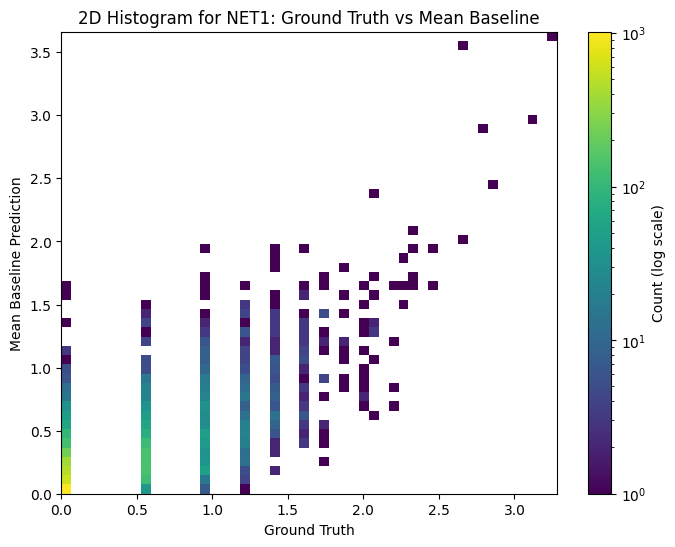

In [124]:
groundtruth = true_expr[p]
pred = predictions[p]
rmse_values = np.mean((groundtruth - pred) ** 2, axis=0)
print(rmse_values)

# Create 2D histogram instead of scatter plot
plt.figure(figsize=(8, 6))
h = plt.hist2d(groundtruth, pred, bins=50, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar(h[3], label='Count (log scale)')
plt.xlabel('Ground Truth')
plt.ylabel('Mean Baseline Prediction')
plt.title(f'2D Histogram for {p}: Ground Truth vs Mean Baseline')

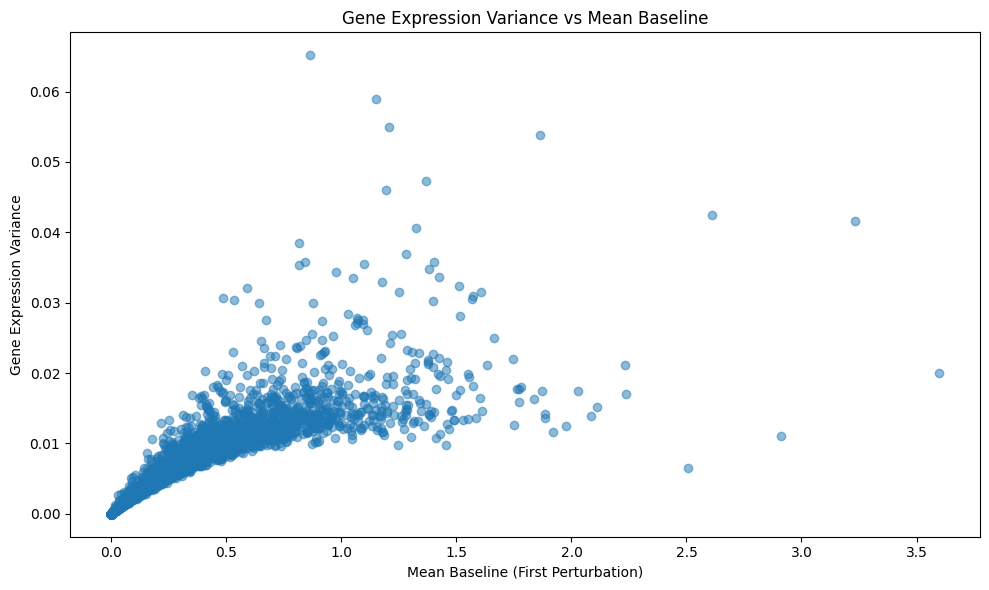

In [216]:
true_expr = sc.get.var_df(adata_stim_d1,adata_stim_d1.obs_names.tolist(), layer='mean')

# Calculate variance for each gene
gene_variance = true_expr.var(axis=1)

# Plot variance vs mean baseline
plt.figure(figsize=(10, 6))
plt.scatter(true_expr.mean(axis=1), gene_variance, alpha=0.5)

plt.xlabel('Mean Baseline (First Perturbation)')
plt.ylabel('Gene Expression Variance')
plt.title('Gene Expression Variance vs Mean Baseline')
plt.tight_layout()

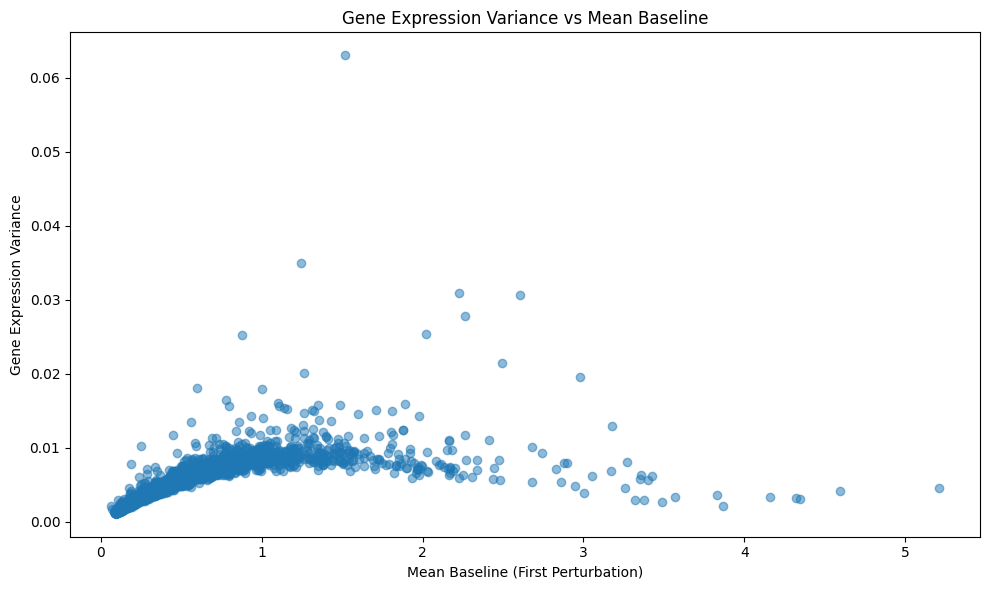

In [215]:
true_expr = sc.get.var_df(adata_k562,adata_k562.obs_names.tolist(), layer='mean')

# Calculate variance for each gene
gene_variance = true_expr.var(axis=1)

# Plot variance vs mean baseline
plt.figure(figsize=(10, 6))
plt.scatter(true_expr.mean(axis=1), gene_variance, alpha=0.5)

plt.xlabel('Mean Baseline (First Perturbation)')
plt.ylabel('Gene Expression Variance')
plt.title('Gene Expression Variance vs Mean Baseline')
plt.tight_layout()

In [133]:
gene_variance.sort_values(ascending=False)

H1-5       0.198612
H1-2       0.175135
RDH10      0.123435
TYMS       0.105530
UCP2       0.104541
             ...   
FAM83A     0.000000
FEV        0.000000
MS4A4A     0.000000
ARHGDIG    0.000000
FLNC       0.000000
Length: 4913, dtype: float64

0.08648769310911203


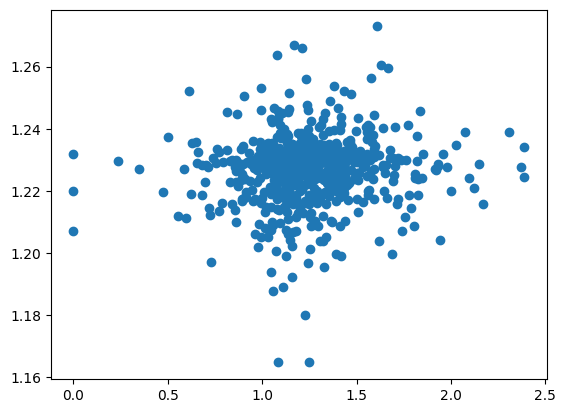

In [144]:
g = 'MYC'
groundtruth = true_expr.loc[g]
pred = predictions.loc[g]
rmse_values = np.mean((groundtruth - pred) ** 2, axis=0)
print(rmse_values)
plt.scatter(groundtruth, pred)
# groundtruth.max()

## Make predictions between donors

In [10]:
def _predict_perturbs(train_adata, control_level='NTC', 
                         train_var_names_col='gene_name', 
                         pca_dim=30, ridge_lambda=0.1, add_baseline=True):
    """
    Predict perturbation effects using a linear model with PCA embeddings.
    
    Parameters:
    -----------
    train_adata : AnnData
        Training data AnnData object
    control_level : str, default='NTC'
        Control perturbation name
    train_var_names_col : str, default='gene_name'
        Column in train_adata.var containing gene names
    test_var_names_col : str, default='gene_name'
        Column in test_adata.var containing gene names
    pca_dim : int, default=30
        Dimension for PCA embedding
    ridge_lambda : float, default=0.1
        Regularization parameter for ridge regression
        
    Returns:
    --------
    pd.DataFrame
        Predicted perturbation effects
    """
    # Create copies to avoid modifying the original objects
    train_adata = train_adata.copy()
    
    # Move gene names to match perturbation ids
    train_adata.var_names = train_adata.var[train_var_names_col].values
    # Predict
    model = PerturbLinearEmbedding(pca_dim=pca_dim, ridge_lambda=ridge_lambda)
    model.fit(train_adata, use_layer='mean', control=control_level)
    predictions = model.predict(add_baseline=add_baseline)
    
    return predictions


In [11]:
predictions_tcells = _predict_perturbs(adata_rest_d1, control_level = 'NTC', add_baseline=True)
predictions_k562 = _predict_perturbs(adata_k562, control_level = 'non-targeting', add_baseline=True)

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['C1orf112', 'GCLC', 'NIPAL3', 'LAS1L', 'ANKIB1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


## Evaluate predictions vs ground truth

In [12]:
# # Get base expression
# baseline = adata_rest_d2['NTC'].layers['mean'].flatten()
# predictions_tcells = predictions_tcells + baseline[:, np.newaxis]
# predictions_k562 = predictions_k562 + baseline[:, np.newaxis]

# stim_d1 = sc.get.var_df(adata_stim_d1, predictions_tcells.columns.tolist(), layer = 'mean')
# stim_d1.index = adata_stim_d1.var['gene_name']
# stim_d1_lfc = stim_d1 - sc.get.var_df(adata_stim_d1, 'NTC', layer = 'mean').values 

stim_d2 = sc.get.var_df(adata_rest_d2, predictions_tcells.columns.tolist(), layer = 'mean')
stim_d2.index = adata_rest_d2.var['gene_name']
stim_d2_lfc = stim_d2 - sc.get.var_df(adata_rest_d2, 'NTC', layer = 'mean').values

# k562 = sc.get.var_df(adata_k562, predictions_k562.columns.tolist(), layer = 'mean')
# k562.index = adata_k562.var['gene_name']
# k562_lfc = k562 - sc.get.var_df(adata_k562, 'non-targeting', layer = 'mean').values

# mean_expr = groundtruth.mean()
# mean_baseline = pd.DataFrame({col: mean_expr for col in groundtruth.columns}, index=mean_expr.index)

In [13]:
top_perturbs = stim_d2_lfc.var().sort_values(ascending=False)[0:1000].index.tolist()

<Axes: xlabel='model', ylabel='l2_distance'>

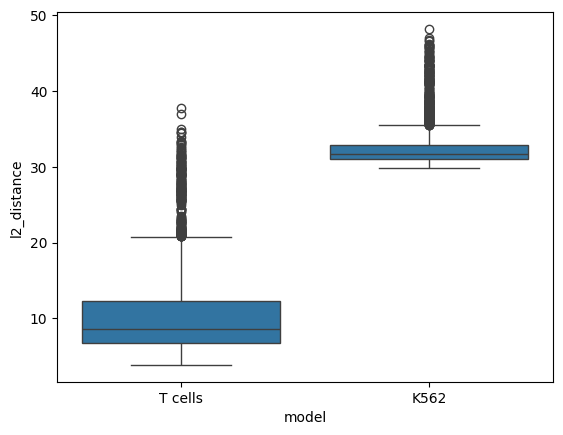

In [14]:
res_k562 = eval_prediction(predictions_k562, stim_d2)
res_tcells = eval_prediction(predictions_tcells, stim_d2)

# Concatenate results in one dataframe
results = pd.concat([
    # results_upper.assign(model='Upper (T-cells same donor)'),
    res_tcells.assign(model='T cells'),
    res_k562.assign(model='K562')
])
results

sns.boxplot(data=results, x='model', y='l2_distance')

In [15]:
results['high_lfc_perturb'] = results['perturbation'].isin(top_perturbs)

<Axes: xlabel='model', ylabel='rmse'>

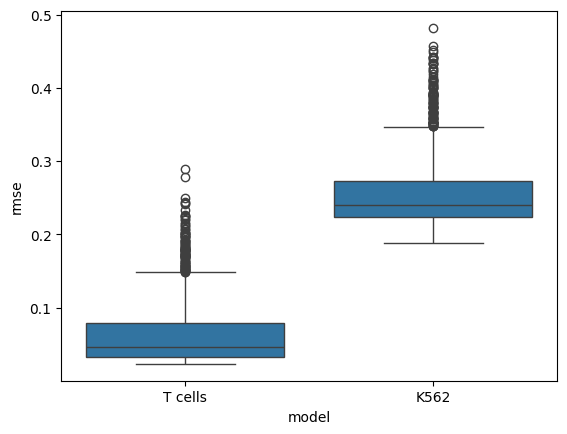

In [16]:
sns.boxplot(data=results[results['high_lfc_perturb']], x='model', y='rmse')

<Axes: xlabel='cosine_distance', ylabel='Count'>

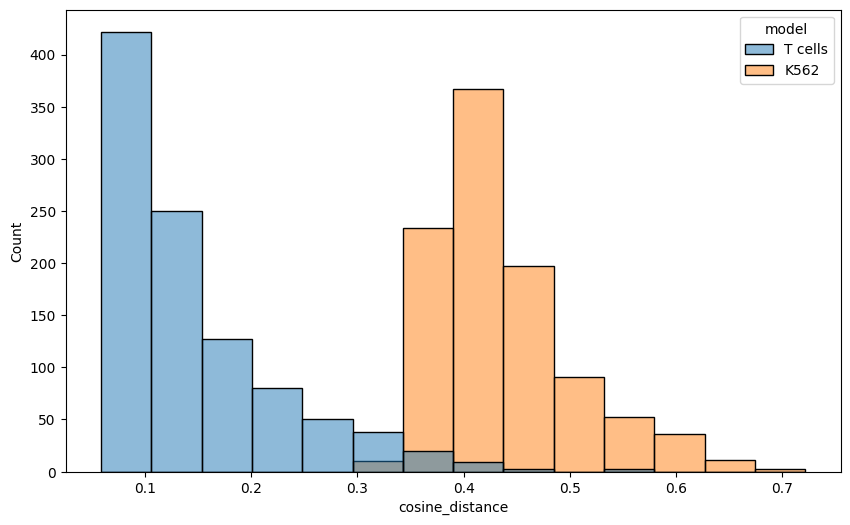

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
# Create histograms for each set of L2 distances
sns.histplot(data = results[results['high_lfc_perturb']], x='cosine_distance', hue='model')

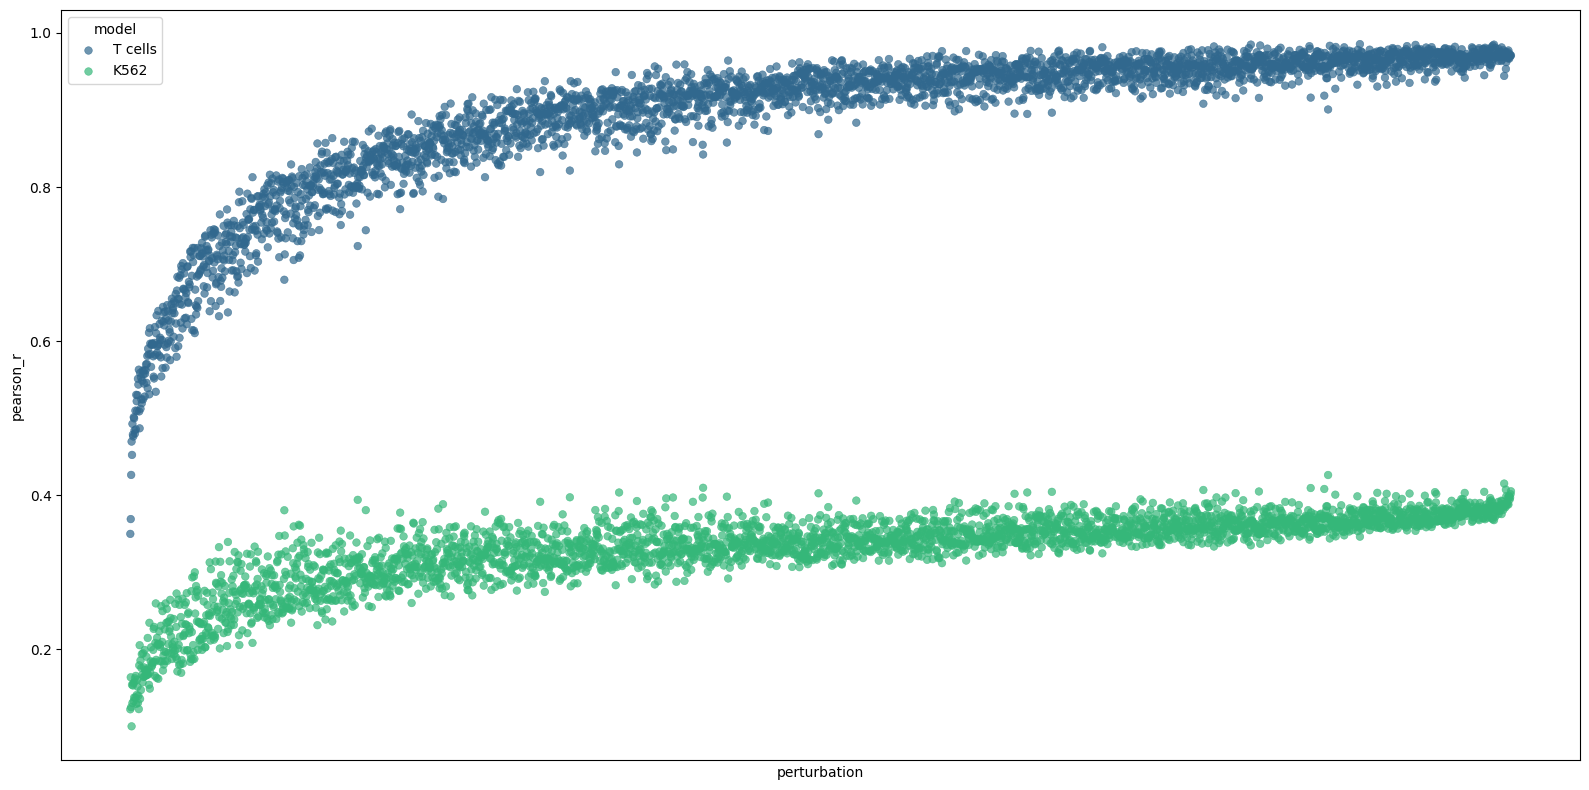

In [18]:
order = results.groupby('perturbation')['pearson_r'].mean().sort_values().index.tolist()
results_ordered = results.copy()
results_ordered['perturbation'] = pd.Categorical(
    results_ordered['perturbation'], 
    categories=order, 
    ordered=True
)
# Plot with the ordered data
plt.figure(figsize=(16, 8))
sns.scatterplot(
    data=results_ordered, 
    x='perturbation', 
    y='pearson_r', 
    hue='model', 
    palette='viridis',
    s=30,  # smaller point size
    alpha=0.7,
    edgecolor=None
)
plt.xticks([])
plt.tight_layout()


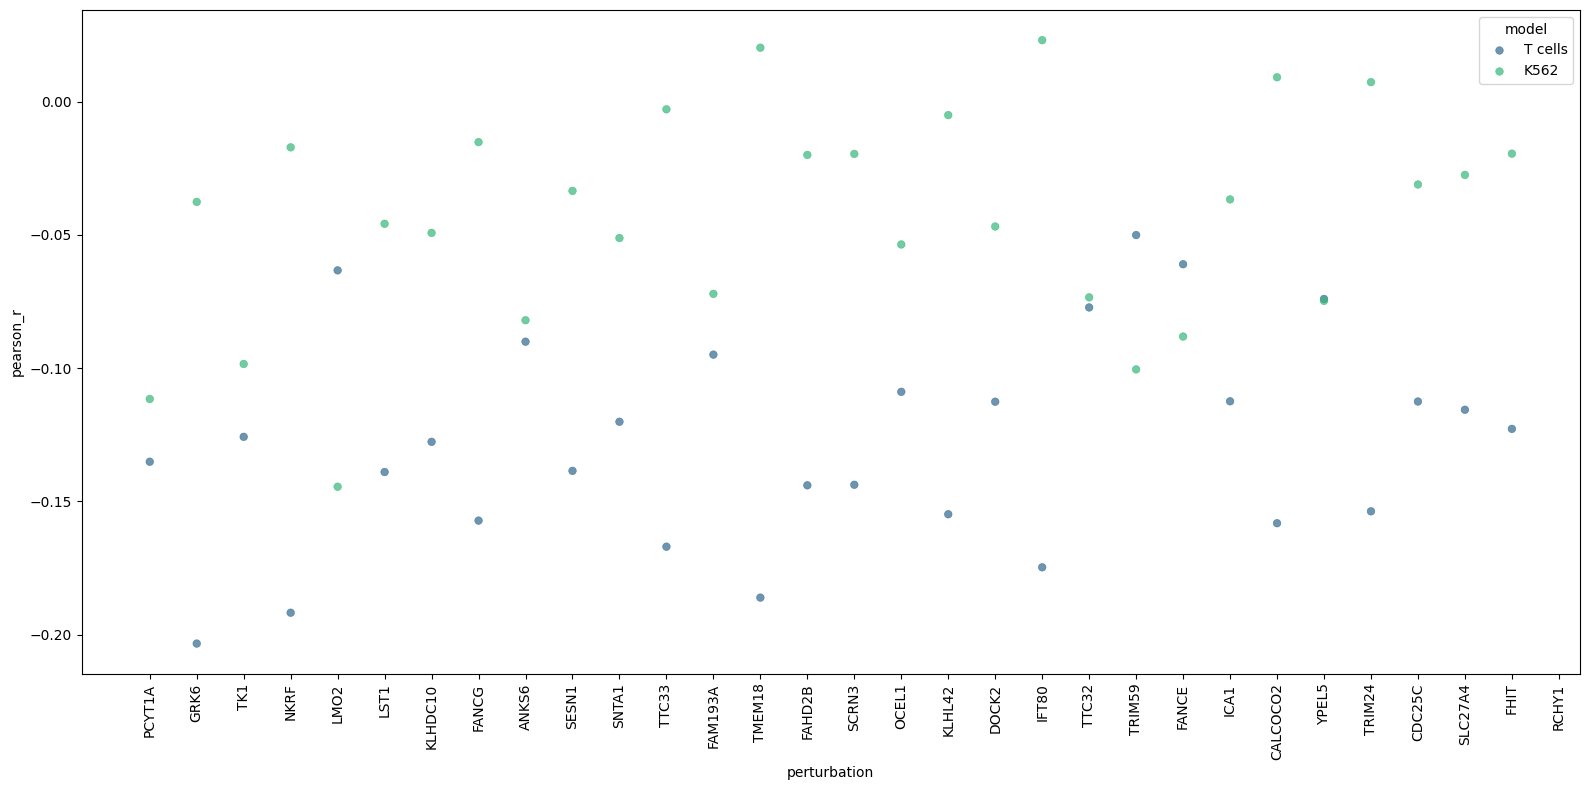

In [110]:
# order = results.groupby('perturbation')['l2_distance'].mean().sort_values().index.tolist()
# results_ordered = results.copy()
# results_ordered['perturbation'] = pd.Categorical(
#     results_ordered['perturbation'], 
#     categories=order, 
#     ordered=True
# )
# Plot with the ordered data
plt.figure(figsize=(16, 8))
sns.scatterplot(
    data=results_ordered[results_ordered.perturbation.isin(order[0:30])], 
    x='perturbation', 
    y='pearson_r', 
    hue='model', 
    palette='viridis',
    s=30,  # smaller point size
    alpha=0.7,
    edgecolor=None
)
plt.xticks(rotation=90)
plt.tight_layout()


NameError: name 'stim_d1_lfc' is not defined

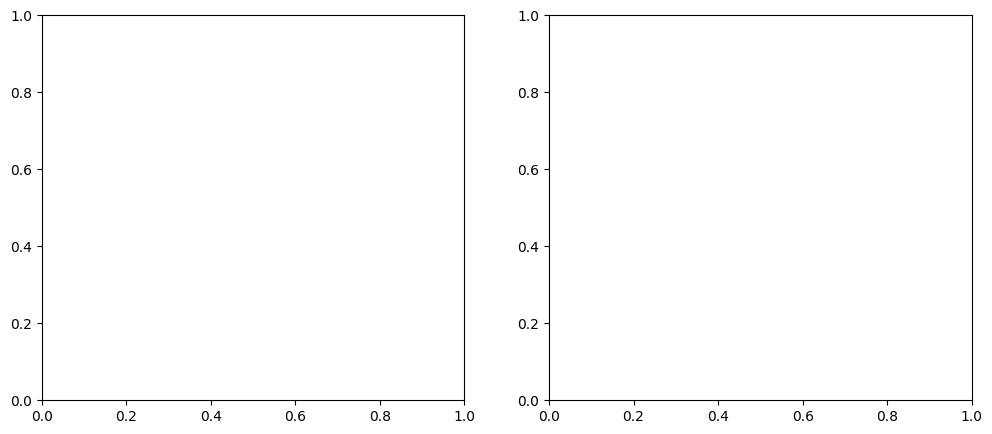

In [156]:
# Define the gene to analyze
gene_name = 'LST1'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# T-cells plot
sns.scatterplot(
    y=stim_d1_lfc[gene_name],
    x=stim_d2_lfc[gene_name],
    edgecolor='none', s=5, alpha=0.5,
    ax=ax1
)
ax1.set_title('T-cells')
ax1.set_xlabel(gene_name)
ax1.set_ylabel(gene_name)
# Calculate correlation for T-cells
corr_tcells = scipy.stats.pearsonr(stim_d1_lfc[gene_name], stim_d2_lfc[gene_name])
ax1.annotate(f"Pearson r: {corr_tcells.statistic:.3f}\np-value: {corr_tcells.pvalue:.2e}", 
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# K562 plot
sns.scatterplot(
    y=stim_d1_lfc[gene_name],
    x=k562_lfc[gene_name],
    edgecolor='none', s=5, alpha=0.5,
    ax=ax2
)
ax2.set_title('K562')
ax2.set_xlabel(gene_name)
ax2.set_ylabel(gene_name)
# Calculate correlation for K562
corr_k562 = scipy.stats.pearsonr(stim_d1_lfc[gene_name], k562_lfc[gene_name])
ax2.annotate(f"Pearson r: {corr_k562.statistic:.3f}\np-value: {corr_k562.pvalue:.2e}", 
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()

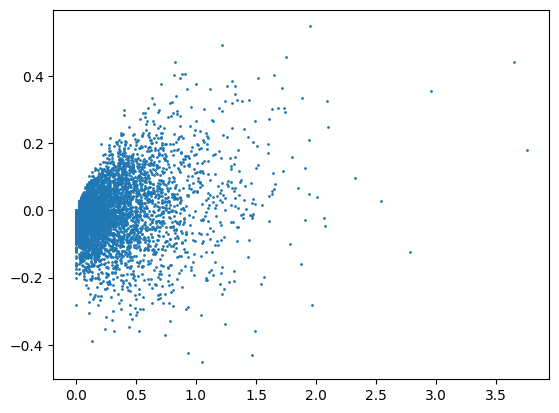

In [118]:
plt.scatter(stim_d1[gene_name], stim_d1_lfc[gene_name], s=1)

Text(0.05, 0.95, 'Pearson r: 1.000\np-value: 0.00e+00')

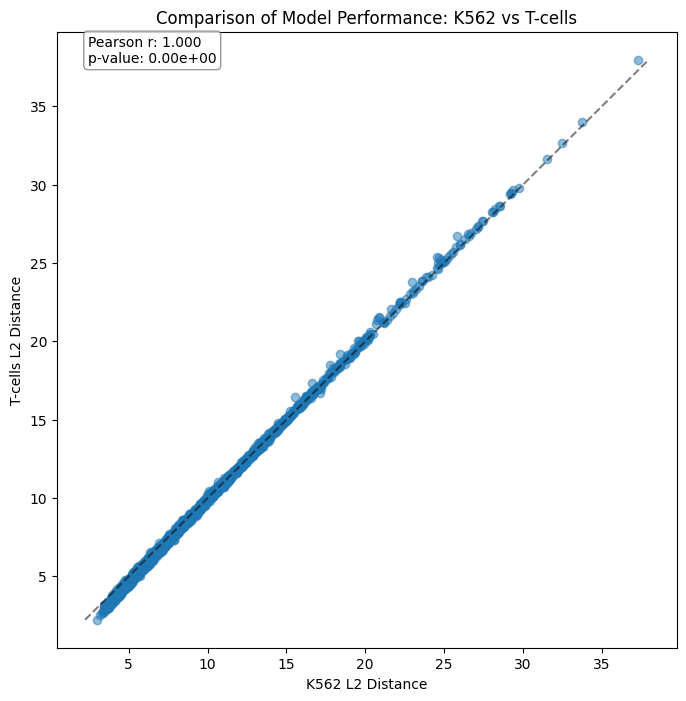

In [78]:
df = results[results['model'] != 'Lower (Mean Baseline)'].pivot(columns='model', index='perturbation', values='l2_distance')
df

# Create a scatterplot comparing K562 vs T-cells models
plt.figure(figsize=(8, 8))
plt.scatter(df['K562'], df['Upper (T-cells)'], alpha=0.5)
plt.plot([df.min().min(), df.max().max()], [df.min().min(), df.max().max()], 'k--', alpha=0.5)  # Add diagonal line
plt.xlabel('K562 L2 Distance')
plt.ylabel('T-cells L2 Distance')
plt.title('Comparison of Model Performance: K562 vs T-cells')

# Calculate correlation
correlation = scipy.stats.pearsonr(df['K562'], df['Upper (T-cells)'])
plt.annotate(f"Pearson r: {correlation.statistic:.3f}\np-value: {correlation.pvalue:.2e}", 
             xy=(0.05, 0.95), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


## Compare differential expression estimates 

This work vs Ota et al. 2025

In [4]:
k562_de = pd.read_table('/mnt/oak/users/mineto/workstation/K562_manuscript_upload/data/Perturbseq/geneLevel/limma_logFC_sum.txt')
k562_de.head()

,GENE,A1BG,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,ENSG00000000419,0.003012,-0.005497,0.069812,0.022973,-0.023051,0.011556,-0.018931,0.034059,-0.097085,...,-0.025697,0.092699,0.002031,-0.012067,-0.009544,0.136223,0.020704,-0.000994,0.018186,0.006207
1,ENSG00000000457,0.015733,-0.015998,-0.016627,0.010174,0.019787,-0.005640,0.034670,-0.023226,-0.008593,...,0.015768,-0.060757,0.009897,-0.030531,0.000062,0.006889,-0.021060,0.020638,-0.004622,-0.004429
2,ENSG00000000460,0.009402,-0.015902,0.029214,-0.025018,-0.009372,0.005226,-0.006175,0.001939,-0.021628,...,0.005717,-0.048654,0.045926,0.029898,0.004641,-0.005476,0.066331,-0.036129,0.004481,0.012778
3,ENSG00000001036,-0.039307,-0.011252,0.055441,-0.033227,-0.003320,0.006539,-0.017273,0.012841,0.110239,...,-0.015569,-0.004124,-0.084547,0.031001,-0.014716,0.023463,0.049053,-0.050969,0.032268,0.000268
4,ENSG00000001084,0.005122,0.004293,0.018793,-0.007727,-0.007050,0.046775,-0.023642,-0.000654,-0.072418,...,0.009773,0.024176,-0.040706,0.013522,0.018091,0.007719,0.031227,-0.006349,-0.008134,-0.028647


In [5]:
k562_de_pvals = pd.read_table('/mnt/oak/users/mineto/workstation/K562_manuscript_upload/data/Perturbseq/geneLevel/limma_P_sum.txt')

In [6]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4iR1_Psomagen/'
experiment_name = 'CD4iR1_Psomagen'

# adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
# adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

### Visualize overlap in DE genes

In [7]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:827: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['PHF23', 'GTSE1', 'SLC25A24', 'C11orf21', 'AMPD2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")


Number of common perturbations between K562 and T-cells: 5966
Number of common genes between K562 and T-cells: 6294


/tmp/ipykernel_2013056/3710469281.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)


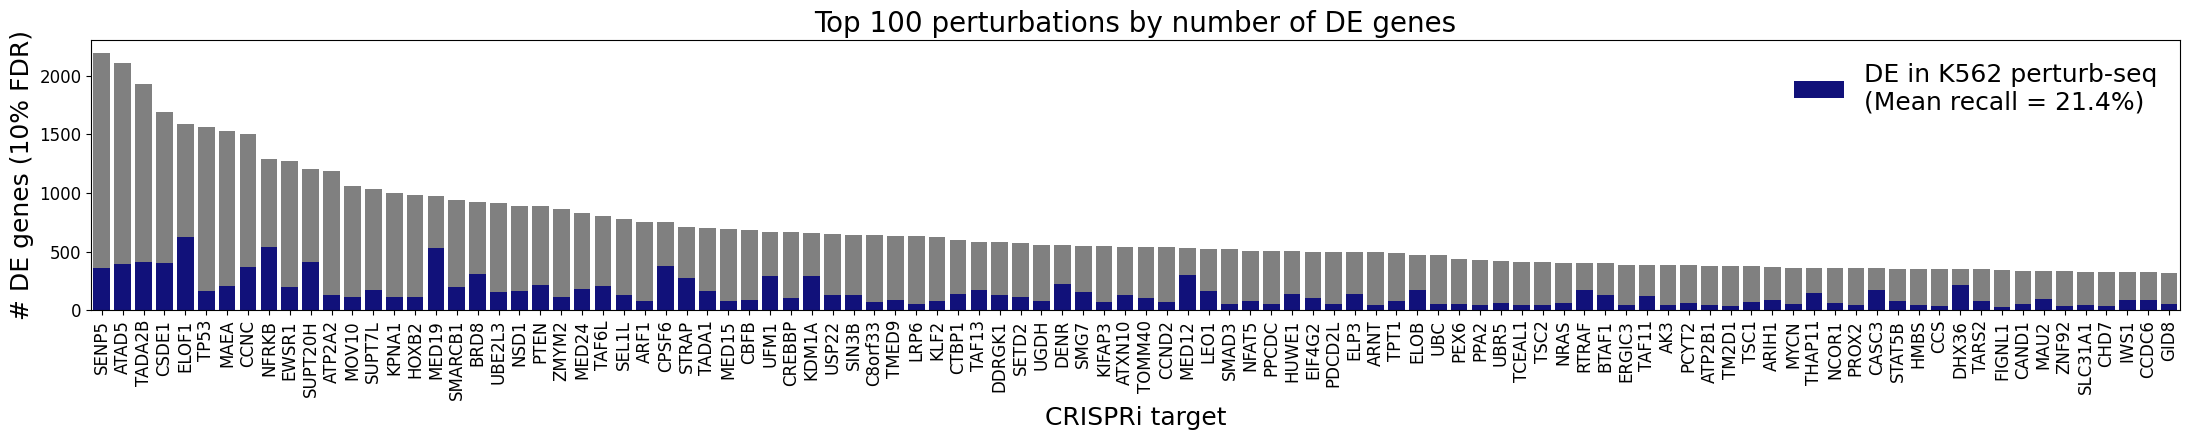

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:827: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['TRIO', 'THAP3', 'KDM4A', 'TIMM21', 'PIBF1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")


Number of common perturbations between K562 and T-cells: 6368
Number of common genes between K562 and T-cells: 6294


/tmp/ipykernel_2013056/3710469281.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)


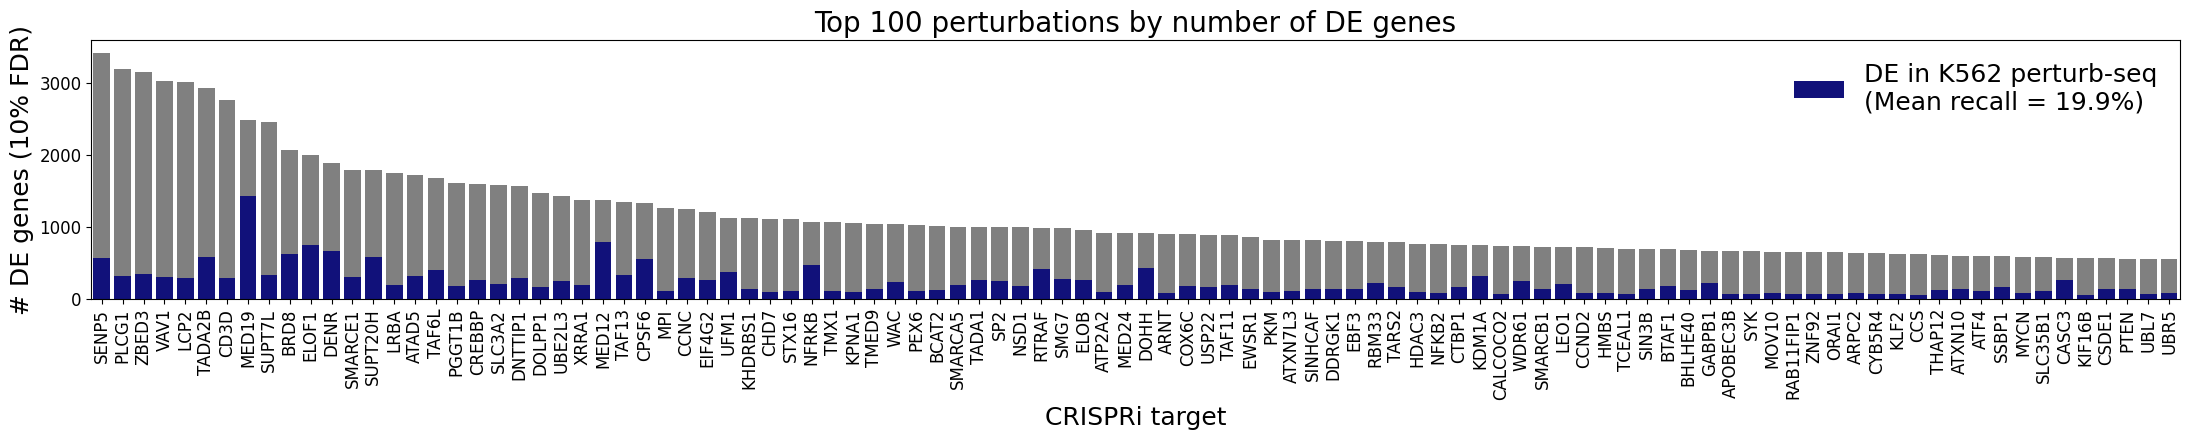

In [8]:
tcells_de_compare_dict = {}
for c in ['Rest', 'Stim8hr']:
    
    adata_de_cond = adata_de[adata_de.obs['culture_condition'] == c]
    adata_de_cond.obs_names = adata_de_cond.obs['target_contrast_gene_name'].copy()
    k562_tested_perturbs = k562_de.columns[1:].tolist()
    tcells_tested_perturbs = adata_de_cond.obs['target_contrast_gene_name'].unique().tolist()
    common_perturbs = np.intersect1d(tcells_tested_perturbs, k562_tested_perturbs)

    # Find common perturbations (already done above)
    print(f"Number of common perturbations between K562 and T-cells: {len(common_perturbs)}")

    # Find common genes tested (rows/var_names)
    k562_tested_genes = k562_de['GENE'].tolist()
    tcells_tested_genes = adata_de_cond.var_names.tolist()
    common_genes = np.intersect1d(k562_tested_genes, tcells_tested_genes)
    print(f"Number of common genes between K562 and T-cells: {len(common_genes)}")

    k562_de_compare = k562_de.set_index('GENE').loc[common_genes, common_perturbs]
    tcells_de_compare = sc.get.var_df(adata_de_cond, common_perturbs.tolist(), layer='log_fc').loc[common_genes]

    k562_de_compare_pvals = k562_de_pvals.set_index('GENE').loc[common_genes, common_perturbs]
    tcells_de_compare_pvals = sc.get.var_df(adata_de_cond, common_perturbs.tolist(), layer='adj_p_value').loc[common_genes]

    alpha = 0.1
    tcells_de_compare_signif = (tcells_de_compare_pvals < alpha).astype(int)
    k562_de_compare_signif = (k562_de_compare_pvals < alpha).astype(int)
    tcells_de_compare_dict[c] = tcells_de_compare.copy()

    # Calculate the number of significant genes in each dataset
    n_signif = (tcells_de_compare_signif).sum()
    n_signif_repl = (tcells_de_compare_signif & k562_de_compare_signif).sum()

    # Create a DataFrame to store the results
    signif_df = pd.DataFrame(
        pd.concat([n_signif, n_signif_repl], axis=1)
    )
    signif_df.columns = ['n_signif', 'K562_repl']
    signif_df = signif_df.reset_index()
    signif_df = signif_df.sort_values('n_signif', ascending=False)

    # Take top 100 perturbations
    pl_signif_df = signif_df.head(100)

    # Create single figure
    fig, ax = plt.subplots(figsize=(22, 4.5))

    # Plot bars
    sns.barplot(data=pl_signif_df, x='index', y='n_signif', ax=ax, color='grey')
    sns.barplot(data=pl_signif_df, x='index', y='K562_repl', ax=ax, color='darkblue', 
                label=f'DE in K562 perturb-seq\n(Mean recall = {np.round(np.mean(pl_signif_df["K562_repl"]/pl_signif_df["n_signif"]) * 100, 1)}%)')

    # Customize plot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)
    ax.set_ylabel('# DE genes (10% FDR)', fontsize=18)
    ax.set_xlabel('CRISPRi target', fontsize=18)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(frameon=False, fontsize=18)

    plt.title('Top 100 perturbations by number of DE genes', fontsize=20)
    plt.tight_layout()
    plt.show()

    # signif_df['K562_recall'] = signif_df['K562_repl']/signif_df['n_signif']
    # sns.scatterplot(data=signif_df[signif_df['n_signif'] > 2], x='n_signif', y='K562_recall', edgecolor='none', alpha=0.5)
    # plt.xscale('log')
    # mean_recall = signif_df[signif_df['n_signif'] > 2]['K562_recall'].mean()
    # plt.axhline(y=mean_recall, color='red', linestyle='--', alpha=0.5, label=f'Mean recall: {mean_recall:.2f}')
    # plt.title(f'Recall of T cell DE genes in K562 cells ({c} condition)', fontsize=14)
    # plt.xlabel('Number of significant genes in T cells', fontsize=12)
    # plt.ylabel('Fraction of DE genes in K562', fontsize=12)
    # plt.legend()
    # plt.show()


/tmp/ipykernel_2013056/3961838564.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)


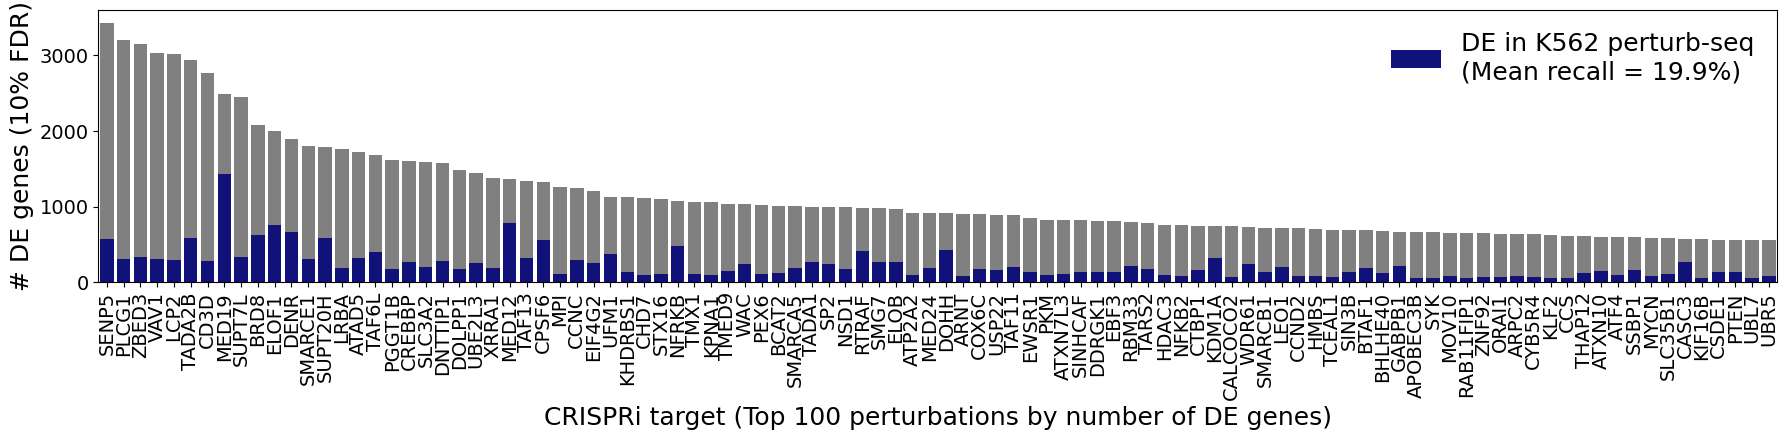

In [19]:
# Create single figure
fig, ax = plt.subplots(figsize=(18, 4.5))

# Plot bars
sns.barplot(data=pl_signif_df, x='index', y='n_signif', ax=ax, color='grey')
sns.barplot(data=pl_signif_df, x='index', y='K562_repl', ax=ax, color='darkblue', 
            label=f'DE in K562 perturb-seq\n(Mean recall = {np.round(np.mean(pl_signif_df["K562_repl"]/pl_signif_df["n_signif"]) * 100, 1)}%)')

# Customize plot
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
ax.set_ylabel('# DE genes (10% FDR)', fontsize=18)
ax.set_xlabel('CRISPRi target (Top 100 perturbations by number of DE genes)', fontsize=18)

ax.tick_params(axis='y', labelsize=14)
ax.legend(frameon=False, fontsize=18)

# plt.title('Top 100 perturbations by number of DE genes', fontsize=20)
plt.tight_layout()
plt.show()


### Correlation between logFCs

In [73]:
tcells_de_compare_dict['Rest']

,A1BG,AAGAB,AAK1,AAMDC,AASDH,ABCA7,ABCB6,ABCB8,ABCB9,ABCC1,...,ZSWIM1,ZSWIM7,ZSWIM8,ZUP1,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1
ENSG00000000419,-0.004124,-0.033174,0.102902,0.045015,-0.086894,-0.127396,-0.093402,0.030430,-0.098850,0.079984,...,0.048061,-0.088360,-0.044556,-0.080724,-0.065942,0.013505,-0.083166,-0.014880,0.041285,-0.087401
ENSG00000000460,0.244184,-0.040205,0.175036,-0.496145,-0.039019,0.519380,0.042397,0.127112,-0.034951,-0.369367,...,-0.075152,0.103291,0.312503,0.079743,0.040756,0.043871,-0.079043,0.084991,0.128915,0.077793
ENSG00000001036,-0.011268,0.231974,0.097918,-0.025903,0.022909,0.563345,0.454698,0.183369,0.308231,0.240361,...,-0.036718,0.418176,0.390500,0.370312,-0.356534,-0.238455,0.140286,-0.058127,0.381053,0.234283
ENSG00000001084,-0.068076,-0.048790,0.094936,-0.005385,0.318049,-0.144799,-0.247230,-0.095143,-0.117555,0.031223,...,-0.077164,0.009072,-0.266411,-0.023507,-0.031364,-0.174898,0.071390,-0.125764,-0.059968,0.017558
ENSG00000001461,-0.079429,-0.083962,-0.228468,0.184850,-0.269578,0.132806,0.298234,0.053610,-0.033700,0.142684,...,0.094643,-0.077927,0.084134,0.023237,0.285659,0.097238,0.093357,0.023052,-0.061032,0.072878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000278828,0.647235,-0.378104,0.208081,-1.018384,-0.105055,0.103491,0.038064,0.068910,0.574863,-0.117411,...,-0.012008,0.162813,0.081976,-0.437242,0.052143,0.479832,0.084136,0.250315,-0.172580,-0.362901
ENSG00000280789,0.045834,-0.000639,0.012377,0.027992,0.106858,-0.028643,-0.307320,0.057531,0.059132,0.209192,...,-0.050995,-0.003648,0.056212,0.213827,-0.389122,0.030473,-0.014229,0.061384,-0.015338,0.016744
ENSG00000284024,0.120755,-0.019594,0.085935,-0.368400,0.173844,0.222059,0.023195,-0.120237,0.055808,0.099380,...,0.223244,-0.189067,0.032458,-0.001851,0.120367,0.059337,-0.161645,0.132175,0.091178,-0.091283
ENSG00000284194,0.186910,0.084847,-0.105495,-0.012279,-0.266870,0.163739,-0.651724,0.035215,-0.702127,-0.015969,...,-0.153710,-0.239541,-0.076270,0.069508,-0.169404,-0.029297,-0.108303,-0.093875,0.080350,0.133192


,A1BG,AAGAB,AAK1,AAMDC,AASDH,ABCA7,ABCB6,ABCB8,ABCC1,ABCC10,...,ZSCAN9,ZSWIM1,ZSWIM7,ZSWIM8,ZUP1,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1
GENE,,,,,,,,,,,,,,,,,,,,,
ENSG00000000419,0.003012,0.022973,-0.023051,0.011556,-0.052458,0.009820,-0.034250,-0.007435,0.025256,0.003896,...,0.005817,0.040075,0.001137,-0.016984,-0.014771,-0.012067,-0.009544,0.136223,0.018186,0.006207
ENSG00000000460,0.009402,-0.025018,-0.009372,0.005226,0.020952,0.000836,-0.001088,0.007558,0.011792,-0.014857,...,-0.010184,0.010292,0.010212,0.014463,0.016976,0.029898,0.004641,-0.005476,0.004481,0.012778
ENSG00000001036,-0.039307,-0.033227,-0.003320,0.006539,0.023116,-0.024326,-0.022910,0.020886,-0.111965,0.088442,...,-0.034100,-0.001372,-0.021154,0.022814,0.012629,0.031001,-0.014716,0.023463,0.032268,0.000268
ENSG00000001084,0.005122,-0.007727,-0.007050,0.046775,0.045698,0.003040,-0.025946,0.033308,0.000272,-0.015851,...,0.001468,-0.018419,0.008680,0.004822,-0.011487,0.013522,0.018091,0.007719,-0.008134,-0.028647
ENSG00000001461,0.013040,0.039459,-0.013276,0.002963,0.001249,0.014348,-0.003696,0.024110,-0.016631,-0.014010,...,-0.019825,-0.025680,-0.003609,-0.001627,0.027042,-0.014780,-0.008984,0.049170,0.002796,-0.009711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000278828,-0.011185,0.017578,-0.013942,0.018320,0.005359,-0.019513,-0.024067,-0.018635,0.002673,0.011732,...,0.005210,0.027073,-0.026138,-0.034172,-0.003899,0.017609,-0.009297,-0.012826,-0.009100,-0.001319
ENSG00000280789,0.006473,0.014182,-0.008235,-0.036215,0.017153,-0.017056,-0.025475,-0.013973,-0.035871,0.001750,...,-0.029339,0.001149,-0.017539,-0.006379,0.007053,0.009161,-0.022545,0.051636,-0.003228,-0.000445
ENSG00000284024,-0.030979,-0.053654,-0.050932,-0.008974,0.038047,-0.008037,-0.007193,0.014056,0.012974,0.003871,...,-0.003230,0.064535,0.008407,0.036610,0.021745,-0.001551,-0.005441,0.048598,-0.006858,-0.006330


In [89]:
common_perturbs = np.intersect1d(tcells_de_compare_dict['Rest'].index, tcells_de_compare_dict['Stim8hr'].index)
common_perturbs = np.intersect1d(common_perturbs, k562_de_compare.index)

common_genes = np.intersect1d(tcells_de_compare_dict['Rest'].columns, tcells_de_compare_dict['Stim8hr'].columns)
common_genes = np.intersect1d(common_genes, k562_de_compare.columns)

print(f"Number of common perturbations: {len(common_perturbs)}")
print(f"Number of common genes: {len(common_genes)}")

Number of common perturbations: 6294
Number of common genes: 5857


In [97]:
df2.loc[common_perturbs]

,A1BG,AAGAB,AAK1,AAMDC,AASDH,ABCA7,ABCB6,ABCB8,ABCC1,ABCC10,...,ZSCAN9,ZSWIM1,ZSWIM7,ZSWIM8,ZUP1,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1
ENSG00000000419,-0.004124,-0.033174,0.102902,0.045015,-0.086894,-0.127396,-0.093402,0.030430,0.079984,0.052359,...,0.010893,0.048061,-0.088360,-0.044556,-0.080724,0.013505,-0.083166,-0.014880,0.041285,-0.087401
ENSG00000000460,0.244184,-0.040205,0.175036,-0.496145,-0.039019,0.519380,0.042397,0.127112,-0.369367,-0.166983,...,0.261083,-0.075152,0.103291,0.312503,0.079743,0.043871,-0.079043,0.084991,0.128915,0.077793
ENSG00000001036,-0.011268,0.231974,0.097918,-0.025903,0.022909,0.563345,0.454698,0.183369,0.240361,-0.300885,...,-0.290904,-0.036718,0.418176,0.390500,0.370312,-0.238455,0.140286,-0.058127,0.381053,0.234283
ENSG00000001084,-0.068076,-0.048790,0.094936,-0.005385,0.318049,-0.144799,-0.247230,-0.095143,0.031223,0.103316,...,0.046851,-0.077164,0.009072,-0.266411,-0.023507,-0.174898,0.071390,-0.125764,-0.059968,0.017558
ENSG00000001461,-0.079429,-0.083962,-0.228468,0.184850,-0.269578,0.132806,0.298234,0.053610,0.142684,-0.002816,...,-0.224061,0.094643,-0.077927,0.084134,0.023237,0.097238,0.093357,0.023052,-0.061032,0.072878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000278828,0.647235,-0.378104,0.208081,-1.018384,-0.105055,0.103491,0.038064,0.068910,-0.117411,-0.159511,...,0.411982,-0.012008,0.162813,0.081976,-0.437242,0.479832,0.084136,0.250315,-0.172580,-0.362901
ENSG00000280789,0.045834,-0.000639,0.012377,0.027992,0.106858,-0.028643,-0.307320,0.057531,0.209192,-0.115581,...,0.106082,-0.050995,-0.003648,0.056212,0.213827,0.030473,-0.014229,0.061384,-0.015338,0.016744
ENSG00000284024,0.120755,-0.019594,0.085935,-0.368400,0.173844,0.222059,0.023195,-0.120237,0.099380,0.226383,...,-0.218473,0.223244,-0.189067,0.032458,-0.001851,0.059337,-0.161645,0.132175,0.091178,-0.091283
ENSG00000284194,0.186910,0.084847,-0.105495,-0.012279,-0.266870,0.163739,-0.651724,0.035215,-0.015969,0.146068,...,0.054806,-0.153710,-0.239541,-0.076270,0.069508,-0.029297,-0.108303,-0.093875,0.080350,0.133192


In [108]:
# Define the comparisons we want to make
comparisons = [
    ('K562_vs_Rest', k562_de_compare[common_genes].T, tcells_de_compare_dict['Rest'][common_genes].T),
    ('K562_vs_Stim', k562_de_compare[common_genes].T, tcells_de_compare_dict['Stim8hr'][common_genes].T),
    ('Rest_vs_Stim', tcells_de_compare_dict['Rest'][common_genes].T, tcells_de_compare_dict['Stim8hr'][common_genes].T)
]

# Create separate DataFrames for each comparison
comparison_results = {}

for comparison_name, df1, df2 in comparisons:
    # Initialize DataFrame for this comparison
    results_df = pd.DataFrame(columns=['Perturbation', 'pearson_r', 'pearson_pval', 
                                      'random_r1', 'random_r2', 'random_r3'])
    
    # Iterate through common perturbations
    for perturb in common_perturbs:
        values1 = df1[perturb]
        values2 = df2[perturb]
        
        # Calculate correlation for the same perturbation
        corr = scipy.stats.pearsonr(values1, values2)
        
        # Calculate random correlations (shuffling column labels 3 times)
        random_rs = []
        for _ in range(3):
            random_perturb = np.random.choice(common_perturbs)
            random_values = df2[random_perturb]
            random_corr = scipy.stats.pearsonr(values1, random_values)
            random_rs.append(random_corr.statistic)
        
        # Add to results DataFrame
        new_row = pd.DataFrame({
            'Perturbation': [perturb],
            'pearson_r': [corr.statistic],
            'pearson_pval': [corr.pvalue],
            'random_r1': [random_rs[0]],
            'random_r2': [random_rs[1]],
            'random_r3': [random_rs[2]]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    # Sort by correlation
    results_df = results_df.sort_values('pearson_r', ascending=False)
    
    # Store in our dictionary
    comparison_results[comparison_name] = results_df

/tmp/ipykernel_3086849/3621580710.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/tmp/ipykernel_3086849/3621580710.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/tmp/ipykernel_3086849/3621580710.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty o

In [109]:
correlation_results = pd.concat([v.assign(comparison=k) for k,v in comparison_results.items()])

/tmp/ipykernel_3086849/3105031229.py:26: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(expected), -np.log10(sorted_p_values_rest_stim), label='Rest vs Stim')


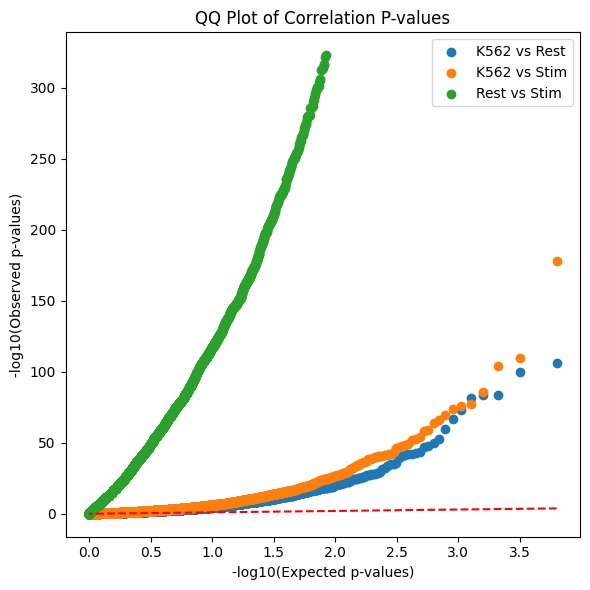

In [110]:
# Get p-values for all comparisons
# Extract p-values from the correlation_results DataFrame
k562_rest_mask = correlation_results['comparison'] == 'K562_vs_Rest'
k562_stim_mask = correlation_results['comparison'] == 'K562_vs_Stim'
rest_stim_mask = correlation_results['comparison'] == 'Rest_vs_Stim'

p_values_k562_rest = correlation_results.loc[k562_rest_mask, 'pearson_pval']
p_values_k562_stim = correlation_results.loc[k562_stim_mask, 'pearson_pval']
p_values_rest_stim = correlation_results.loc[rest_stim_mask, 'pearson_pval']

# Create QQ plots for all three comparisons
plt.figure(figsize=(6, 6))

# Sort the p-values
sorted_p_values_k562_rest = np.sort(p_values_k562_rest)
sorted_p_values_k562_stim = np.sort(p_values_k562_stim)
sorted_p_values_rest_stim = np.sort(p_values_rest_stim)

# Calculate expected values under uniform distribution
n = len(sorted_p_values_k562_rest)
expected = np.arange(1, n+1) / (n+1)

# Plot the QQ plots
plt.scatter(-np.log10(expected), -np.log10(sorted_p_values_k562_rest), label='K562 vs Rest')
plt.scatter(-np.log10(expected), -np.log10(sorted_p_values_k562_stim), label='K562 vs Stim')
plt.scatter(-np.log10(expected), -np.log10(sorted_p_values_rest_stim), label='Rest vs Stim')

# Add reference line
plt.plot([-np.log10(expected).min(), -np.log10(expected).max()], 
         [-np.log10(expected).min(), -np.log10(expected).max()], 
         'r--')

plt.xlabel('-log10(Expected p-values)')
plt.ylabel('-log10(Observed p-values)')
plt.title('QQ Plot of Correlation P-values')
plt.legend()
plt.tight_layout()
plt.show()

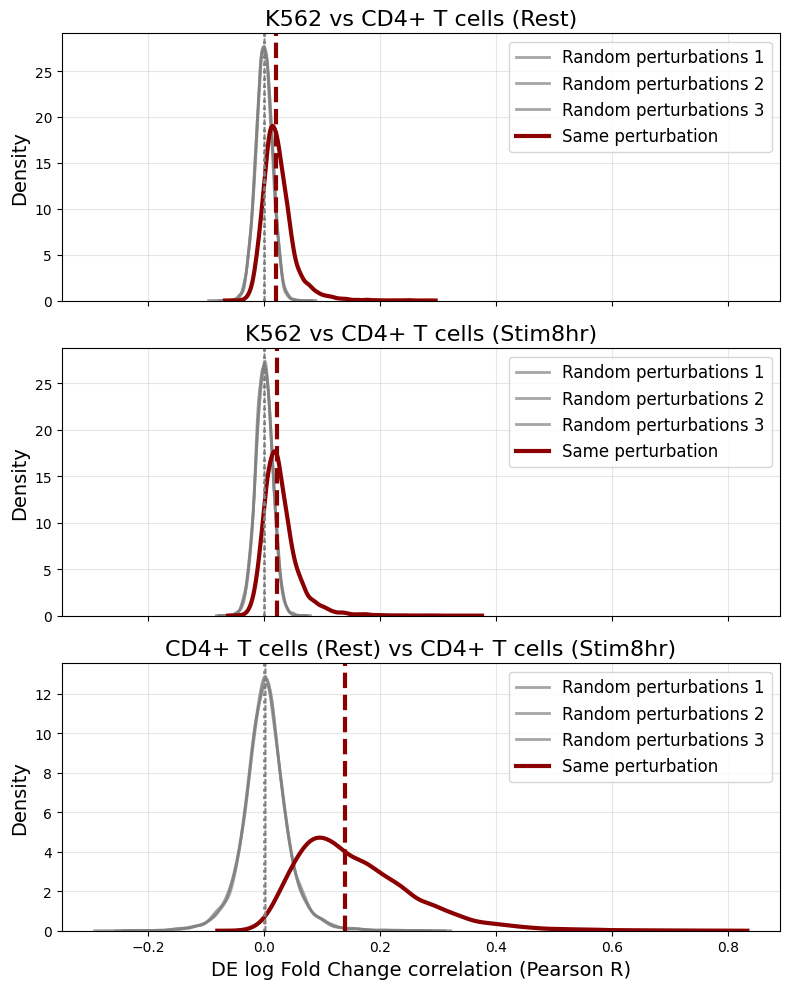

In [111]:
# Create density plots to compare the correlation distributions with random controls
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# Extract correlation values for each comparison
k562_rest_mask = correlation_results['comparison'] == 'K562_vs_Rest'
k562_stim_mask = correlation_results['comparison'] == 'K562_vs_Stim'
rest_stim_mask = correlation_results['comparison'] == 'Rest_vs_Stim'

# Get the pearson_r values for each comparison
k562_rest_corr = correlation_results.loc[k562_rest_mask, 'pearson_r']
k562_stim_corr = correlation_results.loc[k562_stim_mask, 'pearson_r']
rest_stim_corr = correlation_results.loc[rest_stim_mask, 'pearson_r']

# Get the random control correlations for each comparison
random_r1 = correlation_results.loc[k562_rest_mask, 'random_r1']
random_r2 = correlation_results.loc[k562_rest_mask, 'random_r2']
random_r3 = correlation_results.loc[k562_rest_mask, 'random_r3']

# Use colors for main distributions and grey for random controls
main_color = '#8B0000'  # Dark red
random_color = '#7f7f7f'

# Function to create KDE plot for a comparison
def create_kde_plot(ax, main_corr, random_corrs, title):
    # Plot random control distributions
    for i, r_corr in enumerate(random_corrs, 1):
        sns.kdeplot(r_corr, ax=ax, color=random_color, linewidth=2, linestyle='-', 
                   alpha=0.7, label=f'Random perturbations {i}')

    # Plot main correlation distribution
    sns.kdeplot(main_corr, ax=ax, color=main_color, linewidth=3, label='Same perturbation')
    
    
    # Add vertical lines for medians
    ax.axvline(main_corr.median(), color=main_color, linestyle='dashed', linewidth=3)
    for r_corr in random_corrs:
        ax.axvline(r_corr.median(), color=random_color, linestyle='dashed', linewidth=1)
    
    # Add zero line
    ax.axvline(0, color='#7f7f7f', linestyle='dotted', linewidth=2)
    
    # Set labels and styling
    ax.set_xlabel('DE log Fold Change correlation (Pearson R)', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)

# Define the comparisons
comparisons = [
    {'mask': k562_rest_mask, 'corr': k562_rest_corr, 'title': 'K562 vs CD4+ T cells (Rest)', 'ax_idx': 0},
    {'mask': k562_stim_mask, 'corr': k562_stim_corr, 'title': 'K562 vs CD4+ T cells (Stim8hr)', 'ax_idx': 1},
    {'mask': rest_stim_mask, 'corr': rest_stim_corr, 'title': 'CD4+ T cells (Rest) vs CD4+ T cells (Stim8hr)', 'ax_idx': 2}
]

# Create plots for each comparison
for comp in comparisons:
    # Get random controls for this comparison
    random_r1 = correlation_results.loc[comp['mask'], 'random_r1']
    random_r2 = correlation_results.loc[comp['mask'], 'random_r2']
    random_r3 = correlation_results.loc[comp['mask'], 'random_r3']
    random_corrs = [random_r1, random_r2, random_r3]
    
    # Create the plot
    create_kde_plot(axs[comp['ax_idx']], comp['corr'], random_corrs, comp['title'])

plt.tight_layout()
plt.show()


In [114]:
# correlation_results = correlation_results.drop(['condition', 'n_total_de_genes', 'n_cells_target'], axis=1)

In [119]:
correlation_results['condition'] = correlation_results['comparison'].str.split("_vs_").str[1]
correlation_results['condition'] = np.where(correlation_results['condition'] == 'Stim', 'Stim8hr', 'Rest')
stats_df = get_de_stats(adata_de, effect_col='log_fc', signif_col='adj_p_value').rename({'target_name':'Perturbation'}, axis=1)[['Perturbation', 'condition', 'n_total_de_genes', 'n_cells_target']]
correlation_results = pd.merge(correlation_results,stats_df, how='left')

/tmp/ipykernel_3086849/358457900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_df['Perturbation'] = pd.Categorical(pl_df['Perturbation'], categories=order, ordered=True)


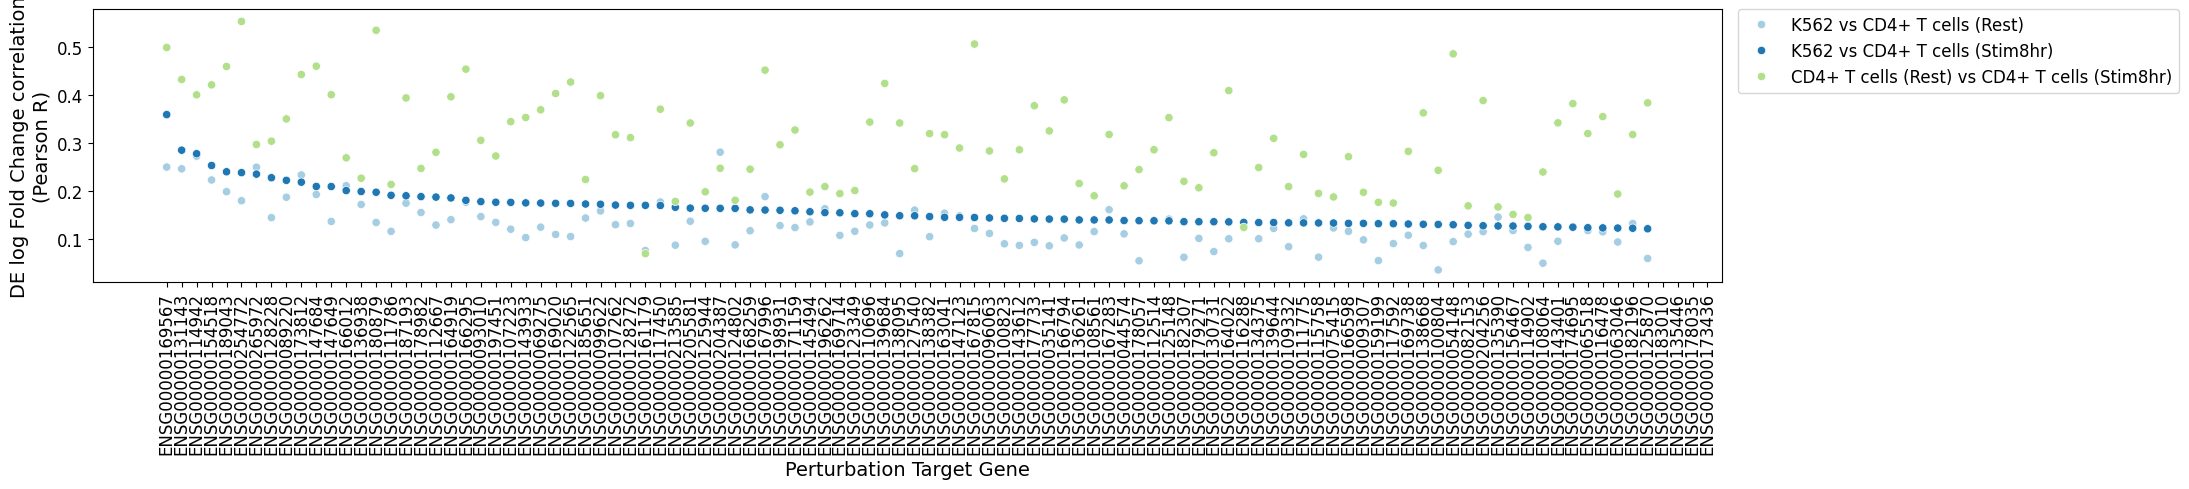

In [123]:
top_correlated_perturbs = correlation_results[correlation_results.comparison == 'K562_vs_Stim'].sort_values('pearson_r', ascending=False)[0:100]['Perturbation'].unique()
pl_df = correlation_results[correlation_results.Perturbation.isin(top_correlated_perturbs)]

# Create a categorical type with ordered categories based on correlation values
order = correlation_results[correlation_results.comparison == 'K562_vs_Stim'].sort_values('pearson_r', ascending=False)['Perturbation'].unique()
pl_df['Perturbation'] = pd.Categorical(pl_df['Perturbation'], categories=order, ordered=True)
plt.figure(figsize=(22, 5))
# Use a paired color palette for better distinction between comparison groups
# Make point size proportional to n_total_de_genes
ax = sns.scatterplot(data=pl_df, x='Perturbation', y='pearson_r', hue='comparison', 
                     palette='Paired')
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Perturbation Target Gene', fontsize=14)
plt.ylabel('DE log Fold Change correlation\n(Pearson R)', fontsize=14)
# Use the same labels as in the comparisons list
legend_labels = {
    'K562_vs_Rest': 'K562 vs CD4+ T cells (Rest)',
    'K562_vs_Stim': 'K562 vs CD4+ T cells (Stim8hr)',
    'Rest_vs_Stim': 'CD4+ T cells (Rest) vs CD4+ T cells (Stim8hr)'
}
handles, labels = ax.get_legend_handles_labels()
# Create cleaner legend labels by removing the comparison prefix
clean_labels = []
for label in labels:
    if label in legend_labels:
        clean_labels.append(legend_labels[label])
    elif label.startswith('n_total_de_genes'):
        clean_labels.append('Number of DE genes')
    else:
        clean_labels.append(label)

# Position legend outside but overlapping with the right side of the plot
ax.legend(handles=handles, labels=clean_labels, fontsize=12, 
          bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

In [101]:
correlated_gs = correlation_results[(correlation_results.comparison.str.startswith('K562')) & (correlation_results['pearson_pval'] < 0.01) & (correlation_results['pearson_r'] > 0)].Perturbation.unique()
correlated_gs = correlated_gs.tolist()
all_gs = correlation_results.Perturbation.unique().tolist()

In [109]:
import gseapy as gp

def parse_gene_sets(filename):
   gene_sets = {}
   with open(filename, 'r') as f:
       for line in f:
           terms = line.strip().split('\t')
           gene_sets[terms[0]] = terms[2:]
   return gene_sets

OAKPATH = '/mnt/oak/'
KEGG_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data//KEGG_2019_Human.txt')
GO_BP_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data/GO_Biological_Process_2023.txt')
GENESETS = {**KEGG_sets, **GO_BP_sets}

# # run enrichr
enr = gp.enrichr(gene_list=correlated_gs,
                gene_sets=GENESETS,
                organism='Human', 
                cutoff=0.1,
                background=all_gs,
                outdir='results/test_enrichr/',
                no_plot=False
                )
enr.results[['Gene_set', 'Term', 'P-value', 'Adjusted P-value', 'Genes']].sort_values('Adjusted P-value')[0:10]



,Gene_set,Term,P-value,Adjusted P-value,Genes
1855,gs_ind_0,"Regulation Of mRNA Splicing, Via Spliceosome (...",0.000001,0.002131,DDX17;SRSF9;ZBTB7A;LARP7;CIRBP;CELF1;HNRNPA1;C...
204,gs_ind_0,Chromatin Remodeling (GO:0006338),0.000011,0.008025,ZBTB7A;MTF2;MBD3;ACTR5;KDM5B;UBR5;CBX3;ATRX;NF...
1769,gs_ind_0,Regulation Of RNA Splicing (GO:0043484),0.000009,0.008025,GRSF1;LARP7;USP22;SUPT7L;SUPT20H;CLK2;CELF1;SL...
1768,gs_ind_0,Regulation Of RNA Metabolic Process (GO:0051252),0.000026,0.013888,GRSF1;USP22;SUPT7L;SUPT20H;CLK2;CELF1;HNRNPA1;...
1549,gs_ind_0,Regulation Of DNA Metabolic Process (GO:0051052),0.000037,0.015531,USP22;HNRNPD;EHMT2;PIF1;SUPT20H;NUCKS1;SUPT7L;...
1556,gs_ind_0,Regulation Of DNA-templated Transcription Elon...,0.000146,0.039302,HMGN1;INTS12;ZC3H4;CCAR2;WDR82
203,gs_ind_0,Chromatin Organization (GO:0006325),0.000150,0.039302,HMGN1;MYSM1;NPM3;ZBTB7A;MTF2;CBX5;MBD3;NUCKS1;...
1552,gs_ind_0,Regulation Of DNA Repair (GO:0006282),0.000127,0.039302,UBR5;USP22;SUPT7L;SUPT20H;ACTR5;BCL7A;DEK;TADA...
1408,gs_ind_0,Protein processing in endoplasmic reticulum,0.000337,0.078601,FBXO6;DNAJB11;XBP1;SSR3;BAG1;SSR4;ERP29;SELENO...
432,gs_ind_0,Histone H3 Acetylation (GO:0043966),0.000507,0.096843,USP22;SUPT7L;SUPT20H;DR1;TADA2B;ATXN7L3


In [108]:
help(gp.enrichr)

Help on function enrichr in module gseapy:

enrichr(gene_list: Iterable[str], gene_sets: Union[List[str], str, Dict[str, str]], organism: str = 'human', outdir: Optional[str] = None, background: Union[List[str], int, str] = None, cutoff: float = 0.05, format: str = 'pdf', figsize: Tuple[float, float] = (6.5, 6), top_term: int = 10, no_plot: bool = False, verbose: bool = False) -> gseapy.enrichr.Enrichr
    Enrichr API.

    :param gene_list: str, list, tuple, series, dataframe. Also support input txt file with one gene id per row.
                      The input `identifier` should be the same type to `gene_sets`.

    :param gene_sets: str, list, tuple of Enrichr Library name(s).
                      or custom defined gene_sets (dict, or gmt file).

                      Examples:

                      Input Enrichr Libraries (https://maayanlab.cloud/Enrichr/#stats):
                        str: 'KEGG_2016'
                        list: ['KEGG_2016','KEGG_2013']
                    

In [25]:
# Fit
use_layer = 'change'
pca_dim = 30

Y = train_adata.layers[use_layer].T.copy()
perturbations = train_adata.obs_names
genes = train_adata.var_names

# Change so that the PCA is computed for all the genes 
pca = TruncatedSVD(n_components=pca_dim)
Y = Y.toarray() if hasattr(Y, 'toarray') else Y
gene_emb = pca.fit_transform(Y)
gene_emb_df = pd.DataFrame(gene_emb, index=genes)
pert_emb_df = gene_emb_df.loc[perturbations].copy()

coefs = solve_y_axb(Y=Y, G=gene_emb_df.values, P=pert_emb_df.values.T, ridge_lambda=0.1)

array([ 1.04586822e-03,  7.92523112e-05,  3.65783996e-03, ...,
       -6.04642961e-04,  2.03810300e-02,  9.11842763e-03])

In [29]:
baseline

ArrayView([0.        , 0.        , 3.15973414, ..., 0.02122446,
           2.17406214, 4.84976985])

In [30]:
# Predict
GWPt = np.matmul(np.matmul(gene_emb_df.values, coefs['K']), pert_emb_df.values.T)
pred = GWPt + coefs['center'][:, np.newaxis] # + baseline[:, np.newaxis]

In [33]:
scipy.stats.pearsonr(Y[:,10], pred[:,10])

PearsonRResult(statistic=0.08049062188121392, pvalue=1.8933740542090147e-27)